In [1]:
pip install sodapy


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip3.9 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
from sodapy import Socrata
import matplotlib.pyplot as plt

In [3]:
# Enrollment data by state
# Source: https://www.kff.org/health-reform/state-indicator/medicaid-expansion-enrollment/?currentTimeframe=0&sortModel=%7B%22colId%22:%22Location%22,%22sort%22:%22asc%22%7D

df_enroll = pd.read_csv('data/KFF_medicaid_enrollment.csv', header=2).loc[:51] # get rid of junk rows
df_enroll = df_enroll.loc[df_enroll['Location'] != 'United States'] # just states & DC
# df_enroll = df_enroll.set_index('Location')
df_enroll = df_enroll.rename(columns={'Expanded by September 30th, 2022':'Enrolled by 2022-09-30'})
df_enroll['Enrolled by 2022-09-30'] = df_enroll['Enrolled by 2022-09-30'].replace({'Yes': True, 'No': False})
df_enroll.head()

,Location,Enrolled by 2022-09-30,Total Medicaid Enrollment,Expansion Group Enrollment,Expansion Group - Newly Eligible Enrollment,Expansion Group - Not Newly Eligible Enrollment
1,Alabama,False,1303099.0,NaN,NaN,NaN
2,Alaska,True,250485.0,71604.0,71602.0,2.0
3,Arizona,True,2394999.0,707942.0,190742.0,517200.0
4,Arkansas,True,1049515.0,342505.0,326906.0,15599.0
5,California,True,14754618.0,4941456.0,4910970.0,30486.0


In [4]:
# Life expectancy by state (2010-2015)
# Docs: https://dev.socrata.com/foundry/data.cdc.gov/5h56-n989

client = Socrata("data.cdc.gov", None)
data = client.get("5h56-n989", where='county_name = "(blank)"')
df_life_exp_src = pd.DataFrame.from_records(data)

# df_life_exp = df_life_exp.set_index('state_name')


In [9]:
df_life_exp = df_life_exp_src.copy()
df_life_exp = df_life_exp.drop('county_name', axis=1)
df_life_exp = df_life_exp.rename(columns={'le':'LE'})
df_life_exp[['LE Range Lower', 'LE Range Upper']] = df_life_exp['le_range'].str.split('-', expand=True)
df_life_exp = df_life_exp.drop(columns=['le_range', 'se_le'])

df_life_exp['LE'] = df_life_exp['LE'].astype(float)
df_life_exp['LE Range Lower'] = df_life_exp['LE Range Lower'].astype(float)
df_life_exp['LE Range Upper'] = df_life_exp['LE Range Upper'].astype(float)

df_life_exp.head()

,state_name,LE,LE Range Lower,LE Range Upper
0,Alabama,75.5,75.2,77.5
1,Alaska,78.8,77.6,79.5
2,Arizona,79.9,79.6,81.6
3,Arkansas,76.0,75.2,77.5
4,California,81.3,79.6,81.6


In [26]:
df_final = df_enroll.merge(df_life_exp, how='inner', left_on='Location', right_on='state_name')
df_final = df_final.drop(columns='state_name')
df_final = df_final.sort_values('LE')
df_final = df_final.reset_index().drop(columns='index')

df_final.head()

,Location,Enrolled by 2022-09-30,Total Medicaid Enrollment,Expansion Group Enrollment,Expansion Group - Newly Eligible Enrollment,Expansion Group - Not Newly Eligible Enrollment,LE,LE Range Lower,LE Range Upper
0,Mississippi,False,825970.0,NaN,NaN,NaN,74.9,56.9,75.1
1,West Virginia,True,652102.0,239001.0,239001.0,0.0,75.3,75.2,77.5
2,Alabama,False,1303099.0,NaN,NaN,NaN,75.5,75.2,77.5
3,Oklahoma,True,1191265.0,334632.0,334632.0,0.0,75.8,75.2,77.5
4,Kentucky,True,1555452.0,627546.0,627546.0,0.0,75.9,75.2,77.5


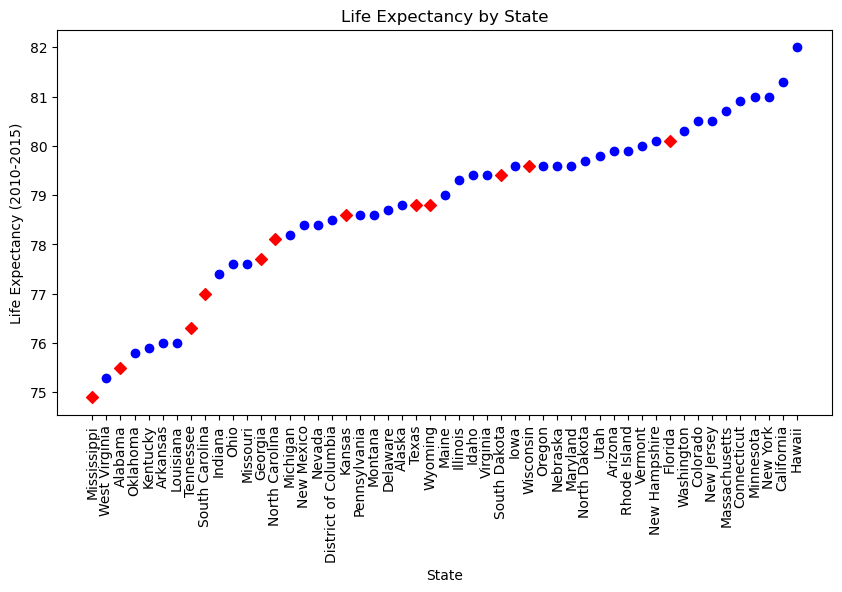

In [34]:
plt.figure(figsize=(10, 5))

for i in range(len(df_final)):
    if df_final.loc[i, 'Enrolled by 2022-09-30']:
        plt.scatter(i, df_final['LE'][i], c='blue', marker='o')
    else:
        plt.scatter(i, df_final['LE'][i], c='red', marker='D')
        
# for i in range(len(df_final)):
#     plt.scatter(i, df_final['LE'][i], c='blue')

# plt.scatter(range(len(df_final)), df_final['LE'], c='blue')
plt.xticks(range(len(df_final)), df_final['Location'], rotation='vertical')

plt.xlabel('State')
plt.ylabel('Life Expectancy (2010-2015)')
plt.title('Life Expectancy by State')

plt.show()

